# Notebook to make plots from saved files

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import jax
import mrcfile
from jax.scipy.special import gammaln
from jax import random
from tqdm import tqdm 
from jaxopt import LBFGS

import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.algorithm import sgd, get_sgd_vol_ops, get_cg_vol_ops, oasis
from src.algorithm import conjugate_gradient as cg
from src.datasets import *
from src.noise import estimate_noise, average_radially, estimate_noise_radial
from src.preprocess import *
from src.fsc import calc_fsc

plt.rcParams["figure.figsize"]=6,6

In [3]:
# We're working with this data:
# data_dir = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/"
# star_file = "particles_crossvalidation_train_1.star"

N0 = 105519
N = 50000
nx0 = 320
nx = 192
nx_crop = 192
pixel_size = 1.31
x_grid = [2.38549618e-03, 1.92000000e+02]
interp_method = "tri"

In [4]:
savefig = False

In [5]:
out_dir = '../data/out_dev/'


In [6]:
mask = jnp.load("../data/out_dev/mask.npy")
mask2d = mask[0].reshape(-1)


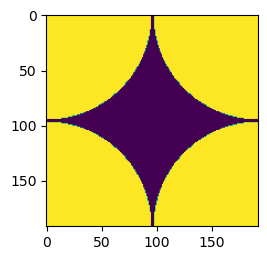

In [7]:
plt.rcParams["figure.figsize"]=6,6

plt.subplot(1,2,1)
plt.imshow(mask[0])

plt.rcParams["figure.figsize"]=6,6

### Preconditioner

In [8]:
interp_method = "tri"
#n_epochs = 2
n_epochs = 400

precon_filename = f"{out_dir}/D0_{interp_method}_nx{nx}_N{N}_{n_epochs}epochs.npy"
D0 = jnp.load(precon_filename)


In [9]:
precon_filename

'../data/out_dev//D0_tri_nx192_N50000_400epochs.npy'

(array([-25.,   0.,  25.,  50.,  75., 100., 125., 150., 175., 200.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

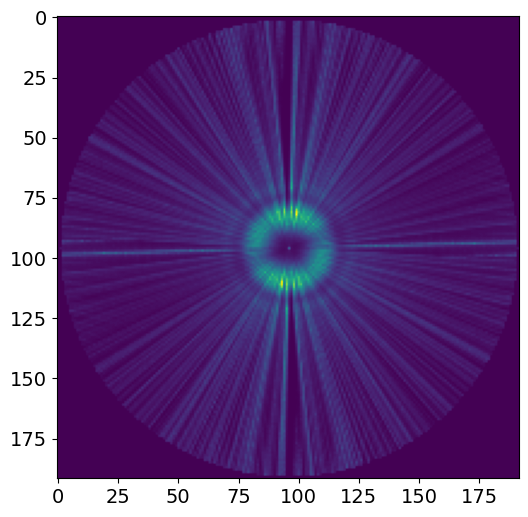

In [10]:
plt.imshow(jnp.fft.fftshift(jnp.abs(D0[0,:,:])));# plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#if savefig:
#    plt.savefig(f"preconditioner_{interp_method}.eps")


### Load iterates

In [11]:
iterates_file_root = f"{out_dir}/iterates_{interp_method}/"


In [12]:
iterates_rec = jnp.load(f"{iterates_file_root}/iterates_rec.npy")
loss_rec = jnp.load(f"{iterates_file_root}/iterates_rec_loss.npy")
step_sizes_rec = jnp.load(f"{iterates_file_root}/step_sizes_rec.npy")

In [13]:
iterates_p_rec1000 = jnp.load(f"{iterates_file_root}/iterates_p_rec1000.npy")
loss_p_rec1000 = jnp.load(f"{iterates_file_root}/iterates_p_rec1000_loss.npy")
step_sizes1000 = jnp.load(f"{iterates_file_root}/step_sizes_p_rec1000.npy")

In [14]:
iterates_o = jnp.load(f"{iterates_file_root}/iterates_o.npy")
loss_o = jnp.load(f"{iterates_file_root}/iterates_o_loss.npy")
step_sizes_o = jnp.load(f"{iterates_file_root}/step_sizes_o.npy")

In [15]:
iterates_o_nothresh = jnp.load(f"{iterates_file_root}/iterates_o_nothresh.npy")
loss_o_nothresh = jnp.load(f"{iterates_file_root}/iterates_o_loss_nothresh.npy")
step_sizes_o_nothresh = jnp.load(f"{iterates_file_root}/step_sizes_o_nothresh.npy")

### Load the L-BFGS volume

In [16]:
# Load
#nnstring = "nn_"
nnstring = ""
N_iters = 750

with mrcfile.open(f"{out_dir}//v_rec_lbfgs_{nnstring}{N_iters}_nx.mrc") as mrc:
    vr_lbfgs = mrc.data
    
v_lbfgs = jnp.fft.fftn(jnp.fft.fftshift((vr_lbfgs)))

In [17]:
# For the L-BFGS loss, copying the value from the grace notebook instead of computing it
loss_lbfgs = 1.56573577e+09

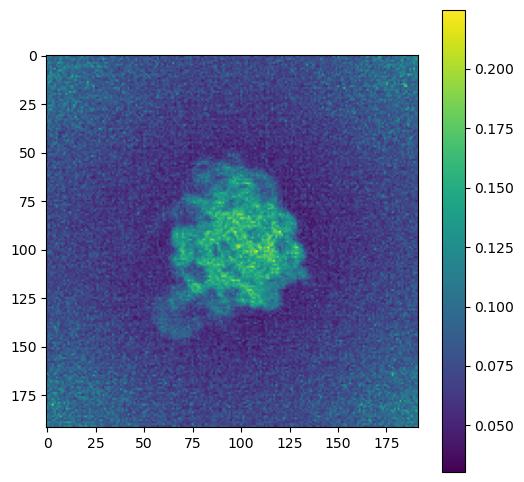

In [18]:
mip_z(vr_lbfgs)
plt.colorbar()

### Make plots

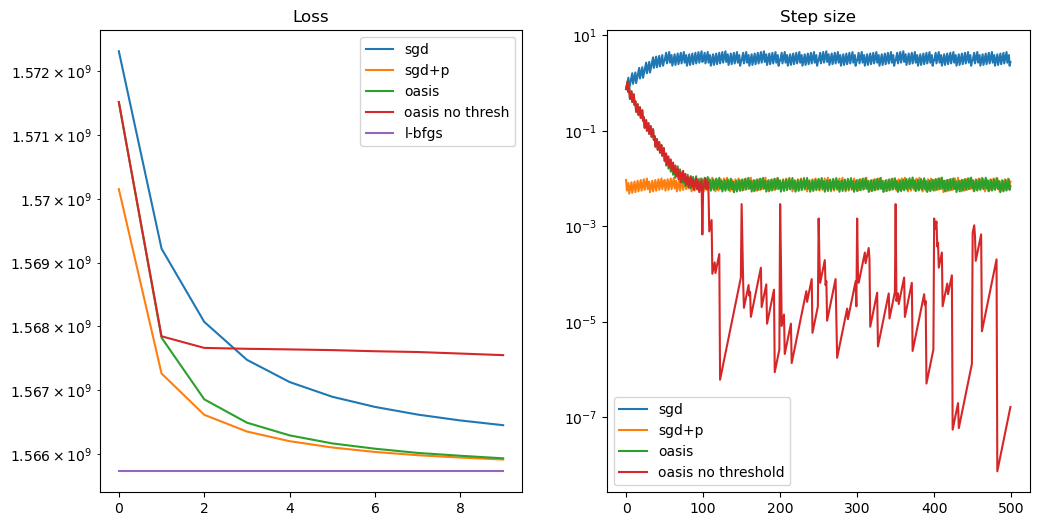

In [19]:
plt.rcParams["figure.figsize"]=12,6

plt.subplot(121)
plt.semilogy(loss_rec)
plt.semilogy(loss_p_rec1000)
plt.semilogy(loss_o)
plt.semilogy(loss_o_nothresh)
plt.semilogy(loss_lbfgs * jnp.ones(loss_rec.shape))
plt.legend(['sgd', 'sgd+p', 'oasis', 'oasis no thresh', 'l-bfgs'])
plt.title("Loss")

plt.subplot(122)
plt.semilogy(step_sizes_rec)
plt.semilogy(step_sizes1000)
plt.semilogy(step_sizes_o)
plt.semilogy(step_sizes_o_nothresh)
plt.legend(['sgd', 'sgd+p', 'oasis', 'oasis no threshold'])
plt.title("Step size")

plt.rcParams["figure.figsize"]=6,6

### Errors and FSCs

In [20]:
from src.fsc import average_shells

def err_px(v1, v2):
    err = 1/2 * jnp.real(jnp.conj(v1-v2)*(v1-v2))
    res, avg_err, n_pts, max_err, median_err = average_shells(err, x_grid)
    
    return jnp.array([avg_err, max_err, median_err])

err_px_iterates = jax.vmap(lambda vv : err_px(v_lbfgs, vv), in_axes=0, out_axes=1)
fsc_iterates = jax.vmap(lambda vv: calc_fsc(v_lbfgs, vv, [1, nx_crop]), in_axes=0, out_axes=1)

In [21]:
averr_rec, maxerr_rec, mederr_rec = err_px_iterates(jnp.array(iterates_rec))
averr_rec_p_1000, maxerr_rec_p_1000, mederr_rec_p_1000 = err_px_iterates(jnp.array(iterates_p_rec1000))
averr_rec_o, maxerr_rec_o, mederr_rec_o = err_px_iterates(jnp.array(iterates_o))
averr_rec_o_nothresh, maxerr_rec_o_nothresh, mederr_rec_o_nothresh = err_px_iterates(jnp.array(iterates_o_nothresh))

print(averr_rec.shape)
print(maxerr_rec.shape)
print(mederr_rec.shape)

(11, 55)
(11, 55)
(11, 55)


In [22]:
res, fsc_sgd, shell_pts = fsc_iterates(jnp.array(iterates_rec))
res, fsc_sgd_p, shell_pts = fsc_iterates(jnp.array(iterates_p_rec1000))
res, fsc_o, shell_pts = fsc_iterates(jnp.array(iterates_o))
res, fsc_o_nothresh, shell_pts = fsc_iterates(jnp.array(iterates_o_nothresh))

print(fsc_sgd.shape)
print(fsc_sgd_p.shape)
print(fsc_o.shape)

(11, 55)
(11, 55)
(11, 55)


In [23]:
# Lower thershold for the preconditioner
# We take this to be the 1/(N points in the largest Fourier shell)
_, _, shell_pts = calc_fsc(D0, D0, [1, D0.shape[0]])
alpha = 1/jnp.max(shell_pts)
print(alpha)
D0hat = jnp.maximum(jnp.abs(D0), alpha)

_, precon_radial_mean, _,  precon_radial_max, precon_radial_median = average_shells((1/jnp.abs(D0)), x_grid)
_, D0_radial_mean, _,  D0_radial_max, D0_radial_median = average_shells(jnp.abs(D0), x_grid)

_, precon_hat_radial_mean, _,  precon_hat_radial_max, precon_hat_radial_median = average_shells((1/D0hat), x_grid)
_, D0hat_radial_mean, _,  D0hat_radial_max, D0hat_radial_median = average_shells(D0hat, x_grid)


5.213981813631434e-06


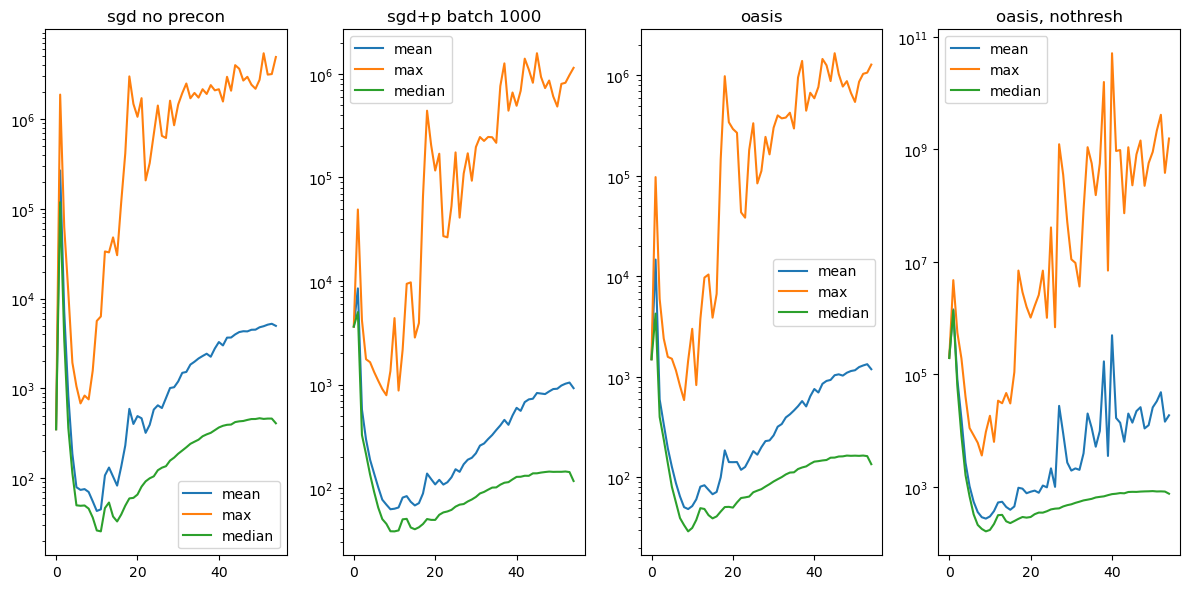

In [24]:
idx = 10

plt.rcParams["figure.figsize"]=12,6

plt.subplot(141)
plt.semilogy((averr_rec[idx]))
plt.semilogy((maxerr_rec[idx]))
plt.semilogy((mederr_rec[idx]))
plt.legend(['mean', 'max', 'median'])
plt.title('sgd no precon')
plt.tight_layout()

plt.subplot(142)
plt.semilogy((averr_rec_p_1000[idx]))
plt.semilogy((maxerr_rec_p_1000[idx]))
plt.semilogy((mederr_rec_p_1000[idx]))
plt.legend(['mean', 'max', 'median'])
plt.title('sgd+p batch 1000')

plt.subplot(143)
plt.semilogy((averr_rec_o[idx]))
plt.semilogy((maxerr_rec_o[idx]))
plt.semilogy((mederr_rec_o[idx]))
plt.legend(['mean', 'max', 'median'])
plt.title('oasis')
plt.tight_layout()

plt.subplot(144)
plt.semilogy((averr_rec_o_nothresh[idx]))
plt.semilogy((maxerr_rec_o_nothresh[idx]))
plt.semilogy((mederr_rec_o_nothresh[idx]))
plt.legend(['mean', 'max', 'median'])
plt.title('oasis, nothresh')
plt.tight_layout()


plt.rcParams["figure.figsize"]=6,6

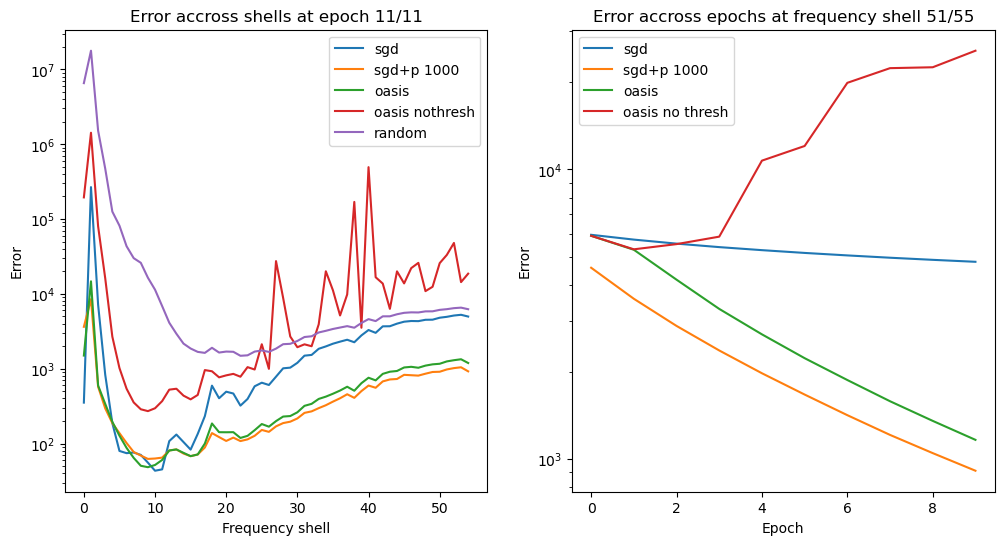

In [25]:
plt.rcParams["figure.figsize"]=12,6

plt.subplot(121)

idx = 10
plt.semilogy(averr_rec[idx])
plt.semilogy(averr_rec_p_1000[idx])
plt.semilogy(averr_rec_o[idx])
plt.semilogy(averr_rec_o_nothresh[idx])
plt.semilogy(averr_rec[0])

plt.legend(['sgd', 'sgd+p 1000', 'oasis', 'oasis nothresh','random'])
plt.xlabel('Frequency shell')
plt.ylabel('Error')
plt.title(f'Error accross shells at epoch {idx+1}/{fsc_sgd.shape[0]}')

plt.subplot(122)

idx_shell = 50
plt.semilogy(averr_rec[1:,idx_shell])
plt.semilogy(averr_rec_p_1000[1:, idx_shell])
plt.semilogy(averr_rec_o[1:, idx_shell])
plt.semilogy(averr_rec_o_nothresh[1:, idx_shell])

plt.legend(['sgd', 'sgd+p 1000', 'oasis', 'oasis no thresh'])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title(f'Error accross epochs at frequency shell {idx_shell+1}/{fsc_sgd.shape[1]}')

plt.rcParams["figure.figsize"]=6,6

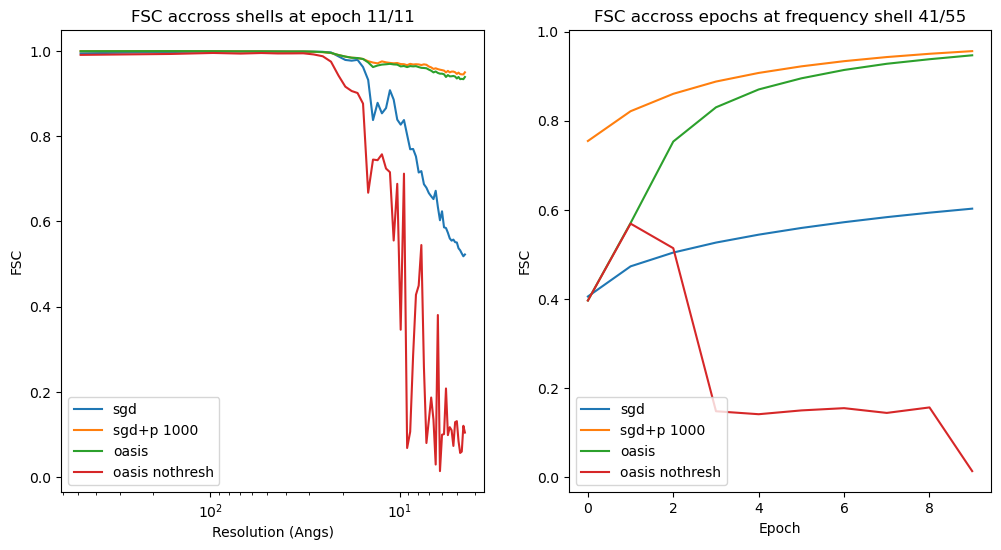

In [26]:
res_angs = nx0 * pixel_size/res[0]

plt.rcParams["figure.figsize"]=12,6

plt.subplot(121)

idx = 10
plt.semilogx(res_angs[1:], fsc_sgd[idx,1:])
plt.semilogx(res_angs[1:], fsc_sgd_p[idx,1:])
plt.semilogx(res_angs[1:], fsc_o[idx,1:])
plt.semilogx(res_angs[1:], fsc_o_nothresh[idx,1:])

plt.gca().invert_xaxis()
plt.legend(['sgd', 'sgd+p 1000', 'oasis', 'oasis nothresh'])
plt.xlabel('Resolution (Angs)')
plt.ylabel('FSC')
plt.title(f'FSC accross shells at epoch {idx+1}/{fsc_sgd.shape[0]}')

plt.subplot(122)

idx_shell = 40
plt.plot(fsc_sgd[1:,idx_shell])
plt.plot(fsc_sgd_p[1:, idx_shell])
plt.plot(fsc_o[1:, idx_shell])
plt.plot(fsc_o_nothresh[1:, idx_shell])


plt.legend(['sgd', 'sgd+p 1000', 'oasis', 'oasis nothresh'])
plt.xlabel('Epoch')
plt.ylabel('FSC')
plt.title(f'FSC accross epochs at frequency shell {idx_shell+1}/{fsc_sgd.shape[1]}')

plt.rcParams["figure.figsize"]=6,6

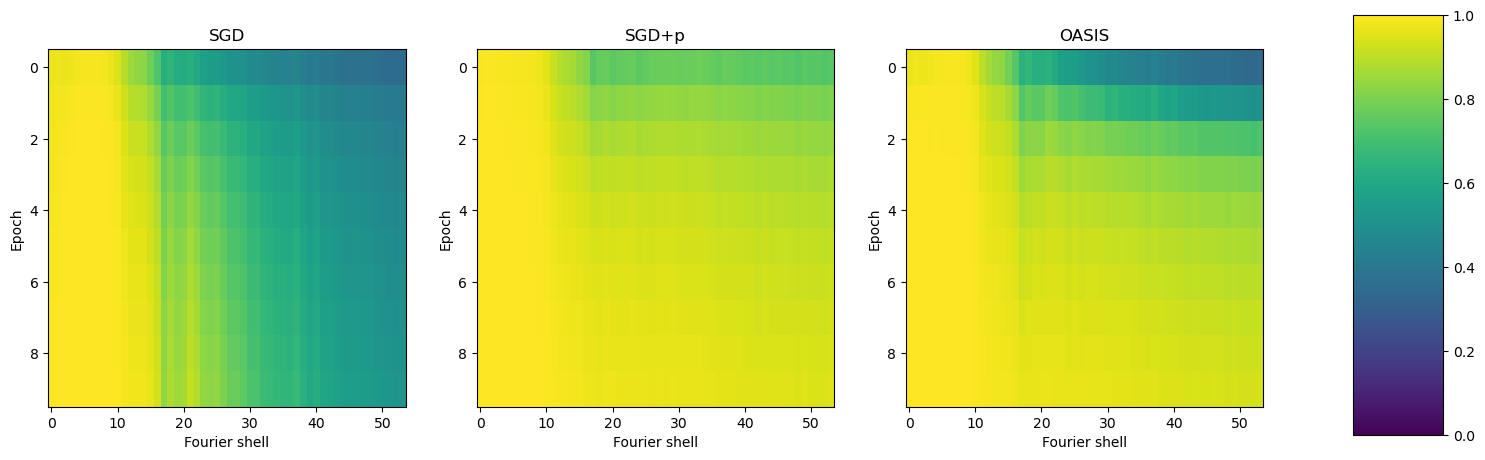

In [27]:
def forceAspect(ax, aspect=1):
    im = ax.get_images()
    extent = im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

plt.rcParams["figure.figsize"]=18, 6

fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(fsc_sgd[1:,1:], vmin=0, vmax=1)
forceAspect(ax)
plt.xlabel('Fourier shell')
plt.ylabel('Epoch')
plt.title('SGD')

ax = fig.add_subplot(132)
ax.imshow(fsc_sgd_p[1:,1:], vmin=0, vmax=1)
forceAspect(ax)
plt.xlabel('Fourier shell')
plt.ylabel('Epoch')
plt.title('SGD+p')

ax = fig.add_subplot(133)
im = ax.imshow(fsc_o[1:,1:], vmin=0, vmax=1)
forceAspect(ax)
plt.xlabel('Fourier shell')
plt.ylabel('Epoch')
plt.title('OASIS')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

In [28]:
print(jnp.min(np.log(averr_rec)))
print(jnp.min(np.log(averr_rec_p_1000)))
print(jnp.min(np.log(averr_rec_o_nothresh)))

print(jnp.max(np.log(averr_rec)))
print(jnp.max(np.log(averr_rec_p_1000)))
print(jnp.max(np.log(averr_rec_o_nothresh)))

clim_min = jnp.min(jnp.array([jnp.min(np.log(averr_rec)), jnp.min(np.log(averr_rec_p_1000)), jnp.min(np.log(averr_rec_o_nothresh))]))
clim_max = jnp.max(jnp.array([jnp.max(np.log(averr_rec)), jnp.max(np.log(averr_rec_p_1000)), jnp.max(np.log(averr_rec_o_nothresh))]))

print(clim_min)
print(clim_max)

3.769794921758298
4.1332622697838
5.603161238732282
16.688771613757062
16.688771613757062
16.688771613757062
3.769794921758298
16.688771613757062


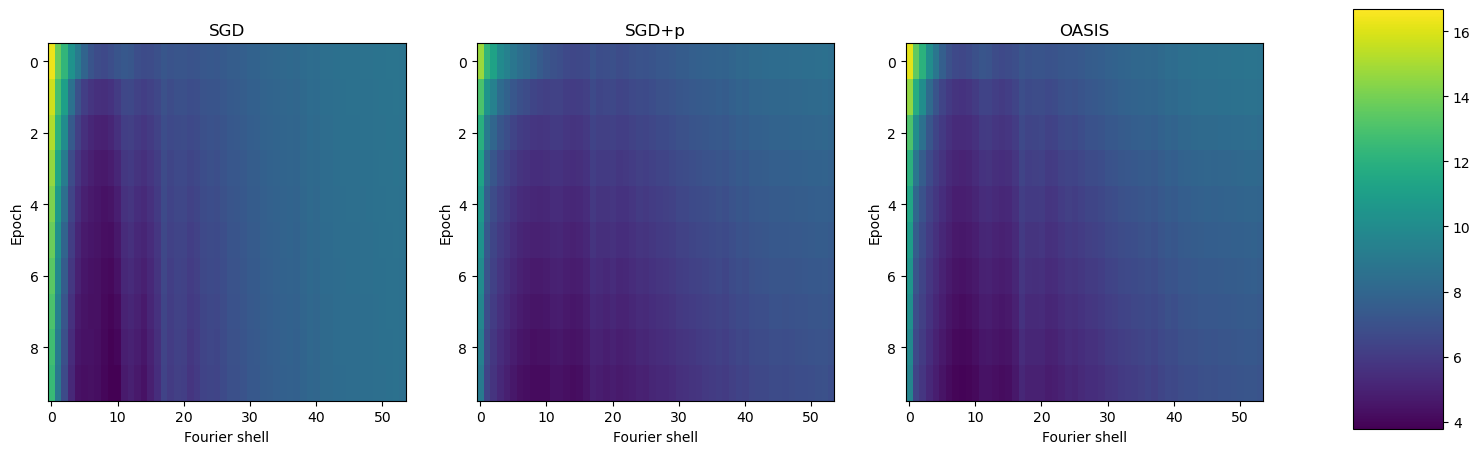

In [29]:
def forceAspect(ax, aspect=1):
    im = ax.get_images()
    extent = im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

plt.rcParams["figure.figsize"]=18, 6

fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(jnp.log(averr_rec[1:,1:]), vmin=clim_min, vmax=clim_max)
forceAspect(ax)
plt.xlabel('Fourier shell')
plt.ylabel('Epoch')
plt.title('SGD')

ax = fig.add_subplot(132)
ax.imshow(jnp.log(averr_rec_p_1000[1:,1:]),  vmin=clim_min, vmax=clim_max)
forceAspect(ax)
plt.xlabel('Fourier shell')
plt.ylabel('Epoch')
plt.title('SGD+p')

ax = fig.add_subplot(133)
im = ax.imshow(jnp.log(averr_rec_o[1:,1:]),  vmin=clim_min, vmax=clim_max)
forceAspect(ax)
plt.xlabel('Fourier shell')
plt.ylabel('Epoch')
plt.title('OASIS')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.rcParams["figure.figsize"]=6, 6

### And the preconditioner too

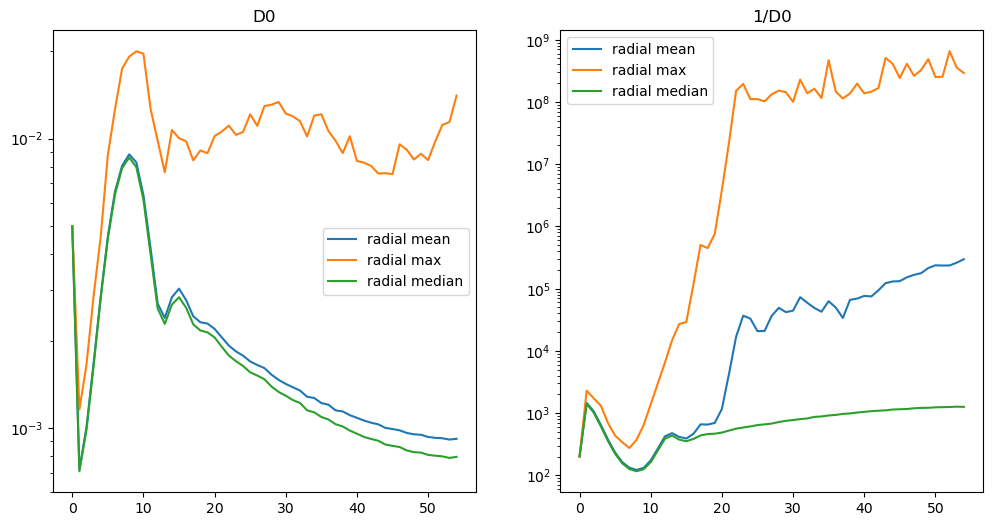

In [30]:
plt.rcParams["figure.figsize"]=12,6

plt.subplot(121)
plt.semilogy(D0_radial_mean)
plt.semilogy(D0_radial_max)
plt.semilogy(D0_radial_median)
plt.legend(['radial mean', 'radial max', 'radial median'])
plt.title('D0')

plt.subplot(122)
plt.semilogy(precon_radial_mean)
plt.semilogy(precon_radial_max)
plt.semilogy(precon_radial_median)
plt.legend(['radial mean', 'radial max', 'radial median'])
plt.title('1/D0')

plt.rcParams["figure.figsize"]=6,6

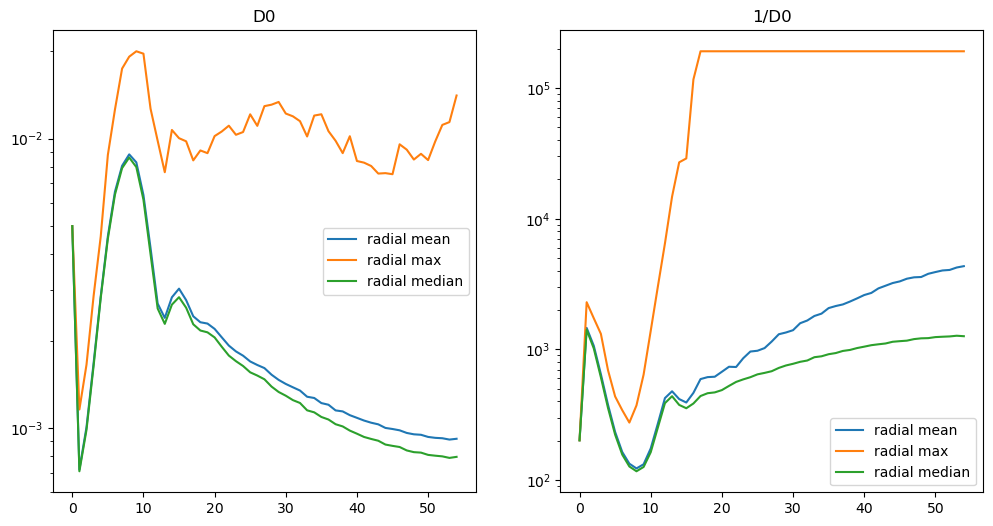

In [31]:
plt.rcParams["figure.figsize"]=12,6

plt.subplot(121)
plt.semilogy(D0hat_radial_mean)
plt.semilogy(D0hat_radial_max)
plt.semilogy(D0hat_radial_median)
plt.legend(['radial mean', 'radial max', 'radial median'])
plt.title('D0')

plt.subplot(122)
plt.semilogy(precon_hat_radial_mean)
plt.semilogy(precon_hat_radial_max)
plt.semilogy(precon_hat_radial_median)
plt.legend(['radial mean', 'radial max', 'radial median'])
plt.title('1/D0')

plt.rcParams["figure.figsize"]=6,6

### Gradient variance

In [32]:
saved_measures_dir = "../data/out_dev/saved_measures/"

In [33]:
grad_full = jnp.load(f"{saved_measures_dir}/grad_full.npy")
var_grad = jnp.load(f"{saved_measures_dir}/var_grad_1000.npy")

In [34]:
_, avgrad_full, _, _, _ = average_shells(jnp.abs(grad_full), x_grid) 
_, av_var_grad, _, _, _ = average_shells(var_grad, x_grid)

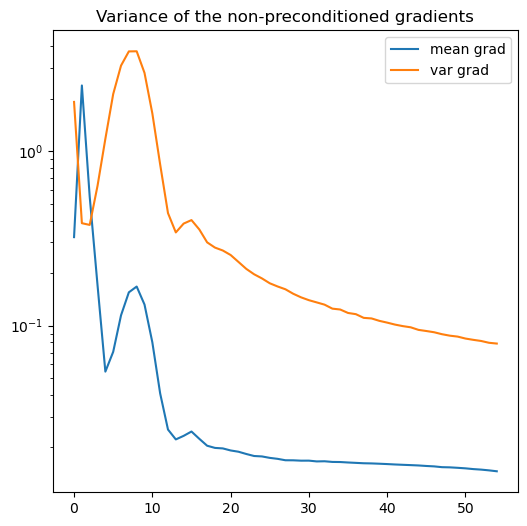

In [35]:
plt.semilogy(jnp.abs(avgrad_full))
plt.semilogy(jnp.abs(av_var_grad))

plt.title('Variance of the non-preconditioned gradients')
plt.legend(['mean grad', 'var grad'])

In [36]:
grad_full_p_d0 = jnp.load(f"{saved_measures_dir}/grad_full_p_d0.npy")
var_grad_p_d0 = jnp.load(f"{saved_measures_dir}/var_grad_1000_p_d0.npy")

In [37]:
_, avgrad_full_p_d0, _, _, _ = average_shells(jnp.abs(grad_full_p_d0), x_grid) 
_, av_var_grad_p_d0, _, _, _ = average_shells(var_grad_p_d0, x_grid)

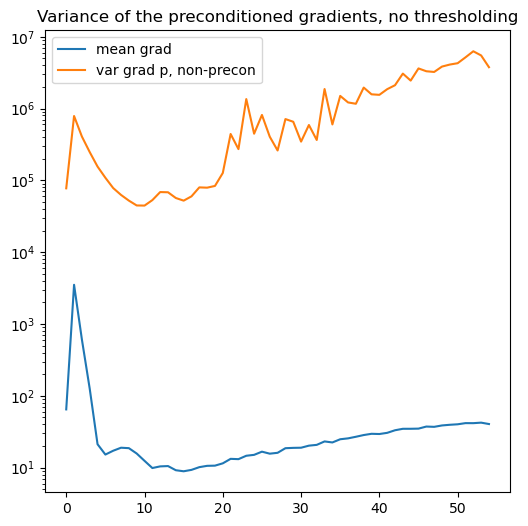

In [38]:
plt.semilogy(jnp.abs(avgrad_full_p_d0))
plt.semilogy(jnp.abs(av_var_grad_p_d0))

plt.title('Variance of the preconditioned gradients, no thresholding')
plt.legend(['mean grad', 'var grad p, non-precon'])

In [39]:
grad_full_p_dhat = jnp.load(f"{saved_measures_dir}/grad_full_p_dhat.npy")
var_grad_p_dhat = jnp.load(f"{saved_measures_dir}/var_grad_1000_p_dhat.npy")

In [40]:
_, avgrad_full_p_dhat, _, _, _ = average_shells(jnp.abs(grad_full_p_dhat), x_grid) 
_, av_var_grad_p_dhat, _, _, _ = average_shells(var_grad_p_dhat, x_grid)

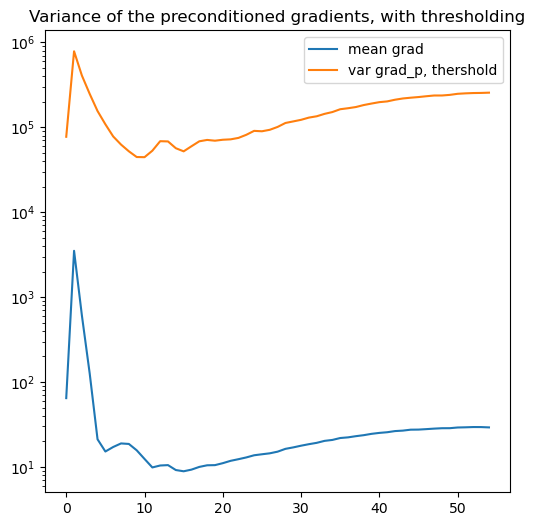

In [41]:
plt.semilogy(jnp.abs(avgrad_full_p_dhat))
plt.semilogy(jnp.abs(av_var_grad_p_dhat))

plt.title('Variance of the preconditioned gradients, with thresholding')
plt.legend(['mean grad', 'var grad_p, thershold'])

#### The error and the variance of the _preconditioned_ gradient go up at the same time, so they are related, so maybe their common thing is the problem: the preconditioner

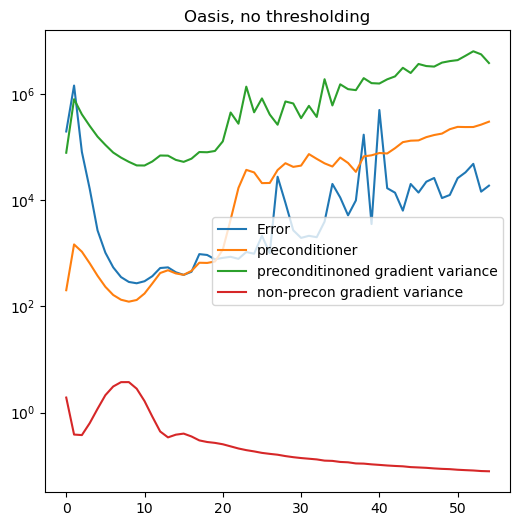

In [42]:
# Before thresholding: 

plt.semilogy(averr_rec_o_nothresh[10])
plt.semilogy(precon_radial_mean)
plt.semilogy(jnp.abs(av_var_grad_p_d0))
plt.semilogy(av_var_grad)
plt.title("Oasis, no thresholding")
plt.legend(['Error', 'preconditioner', 'preconditinoned gradient variance', 'non-precon gradient variance'])

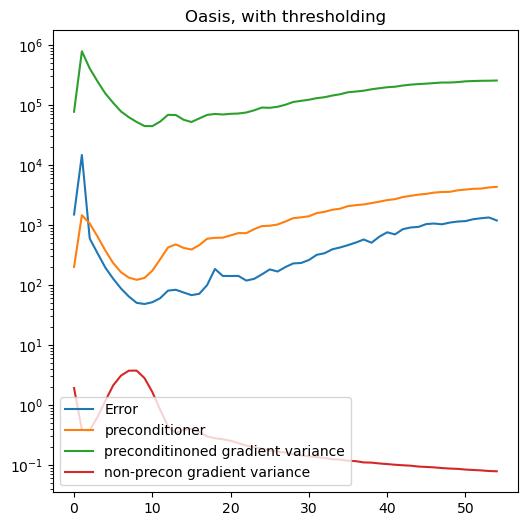

In [43]:
# After thresholding
plt.semilogy(averr_rec_o[10])
plt.semilogy(precon_hat_radial_mean)
plt.semilogy(jnp.abs(av_var_grad_p_dhat))
plt.semilogy(av_var_grad)
plt.title("Oasis, with thresholding")
plt.legend(['Error', 'preconditioner', 'preconditinoned gradient variance', 'non-precon gradient variance'])

# Custom plots

### The nn preconditioner

In [228]:
savefig = False

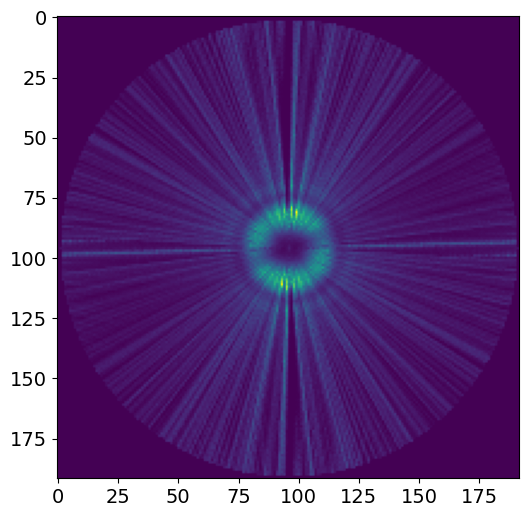

In [197]:
interp_method = "nn"
n_epochs = 2
#n_epochs = 400

precon_filename = f"{out_dir}/D0_{interp_method}_nx{nx}_N{N}_{n_epochs}epochs.npy"
D0 = jnp.load(precon_filename)

plt.imshow(jnp.fft.fftshift(jnp.abs(D0[0,:,:])));# plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.title("Diagonal of $H$", fontsize=22)
#plt.title("Diagonal of $H$ for $N=50000$", fontsize=22)



if savefig:
    plt.savefig(f"preconditioner_{interp_method}.eps", bbox_inches='tight')

### Before thresholding

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


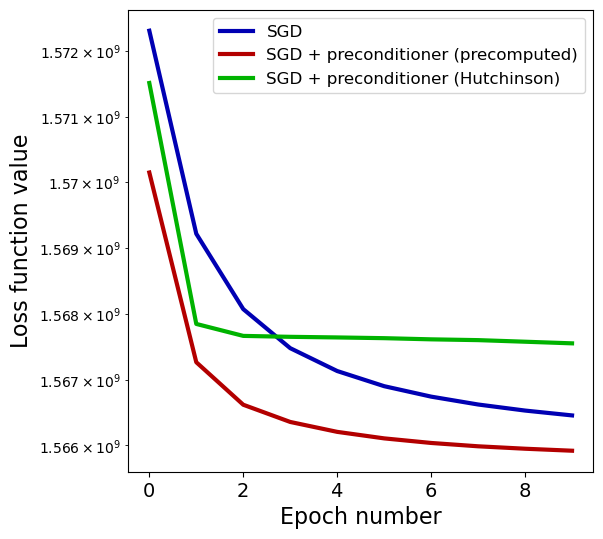

In [205]:
plt.plot
plt.semilogy(loss_rec, linewidth=3, c=(0,0,0.7))
plt.semilogy(loss_p_rec1000, linewidth=3, c=(0.7,0,0))#, linestyle='dotted')
#plt.semilogy(loss_o)
plt.semilogy(loss_o_nothresh, linewidth=3, c=(0,0.7,0))#, linestyle='dashed')
#plt.semilogy(loss_lbfgs * jnp.ones(loss_rec.shape))
plt.legend(['SGD', 'SGD + preconditioner (precomputed)', 'SGD + preconditioner (Hutchinson)'], fontsize=12)
#plt.title("Loss", fontsize=22)
plt.xlabel("Epoch number", fontsize=16)
plt.ylabel("Loss function value", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

if savefig:
    plt.savefig(f"pre_thresh_epoch_loss.eps")#, bbox_inches='tight')

In [227]:
savefig = False

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


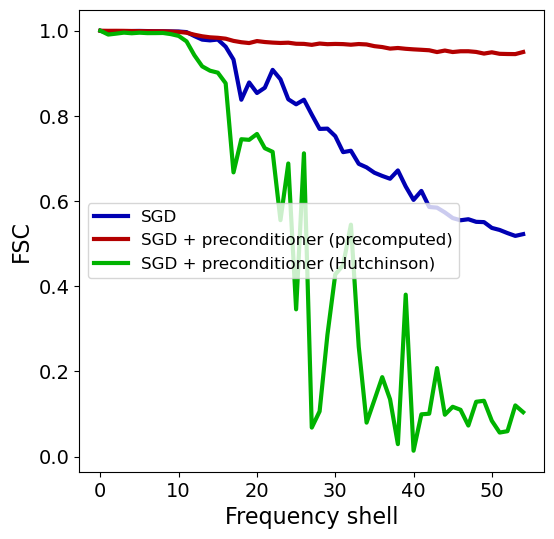

In [206]:
plt.plot((fsc_sgd[10]), linewidth=3, c=(0,0,0.7))
plt.plot((fsc_sgd_p[10]), linewidth=3, c=(0.7,0,0))
plt.plot((fsc_o_nothresh[10]), linewidth=3, c=(0,0.7,0))
plt.legend(['SGD', 'SGD + preconditioner (precomputed)', 'SGD + preconditioner (Hutchinson)'], fontsize=12)
#plt.title("Fourier shell correlation (final epoch)", fontsize=22)
plt.xlabel("Frequency shell", fontsize=16)
plt.ylabel("FSC", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

if savefig:
    plt.savefig(f"pre_thresh_shell_error.eps")#, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


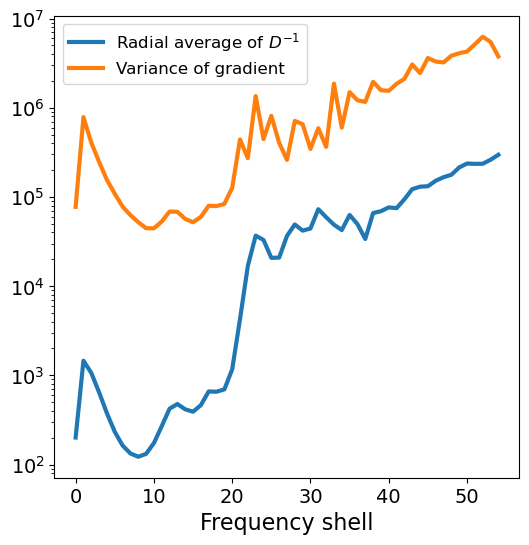

In [207]:


#ax1.semilogy(fsc_o_nothresh[10], linewidth=3, color='g')


plt.semilogy(precon_radial_mean, linewidth=3)
plt.semilogy(jnp.abs(av_var_grad_p_d0), linewidth=3)
plt.legend(['Radial average of $D^{-1}$', 'Variance of gradient'], fontsize=12)
#plt.title("Grad variance and $D^{-1}$ (final epoch)", fontsize=22)
plt.xlabel("Frequency shell", fontsize=16)
#plt.ylabel("FSC", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

if savefig:
    plt.savefig(f"pre_thresh_shell_error_variance.eps")#, bbox_inches='tight')

### After thresholding

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


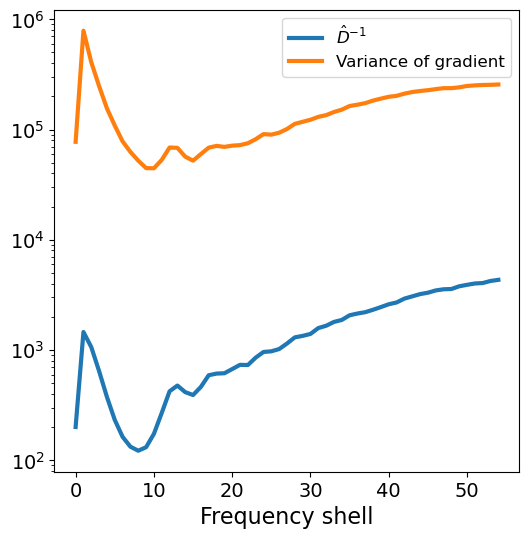

In [216]:
plt.semilogy(precon_hat_radial_mean, linewidth=3)
plt.semilogy(jnp.abs(av_var_grad_p_dhat), linewidth=3)

#plt.semilogy((fsc_o[10]), linewidth=3)
plt.legend(['$\hat{D}^{-1}$', 'Variance of gradient'], fontsize=12)

#plt.title("Grad variance and $\hat{D}^{-1}$ (final epoch)", fontsize=22)
plt.xlabel("Frequency shell", fontsize=16)
#plt.ylabel("Error", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

if savefig:
    plt.savefig(f"post_thresh_shell_error_variance.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


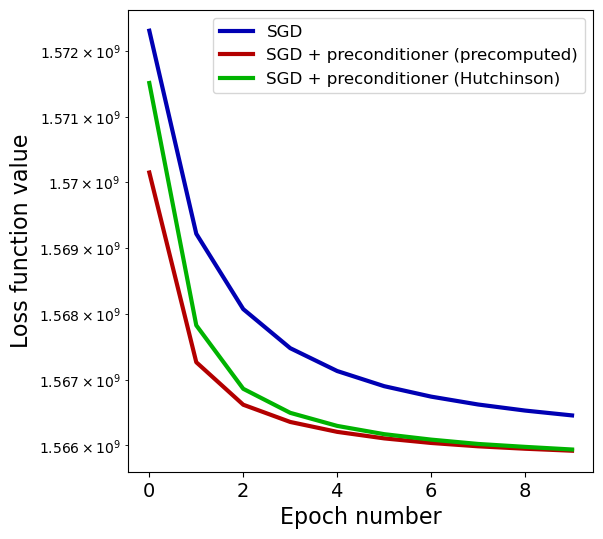

In [217]:
plt.plot
plt.semilogy(loss_rec, linewidth=3, c = (0,0,0.7))
plt.semilogy(loss_p_rec1000, linewidth=3, c=(0.7,0,0))
#plt.semilogy(loss_o)
plt.semilogy(loss_o, linewidth=3, c=(0,0.7,0))
#plt.semilogy(loss_lbfgs * jnp.ones(loss_rec.shape))
plt.legend(['SGD', 'SGD + preconditioner (precomputed)', 'SGD + preconditioner (Hutchinson)'], fontsize=12)
#plt.title("Loss", fontsize=22)
plt.xlabel("Epoch number", fontsize=16)
plt.ylabel("Loss function value", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

if savefig:
    plt.savefig(f"post_thresh_epoch_loss.eps")#, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


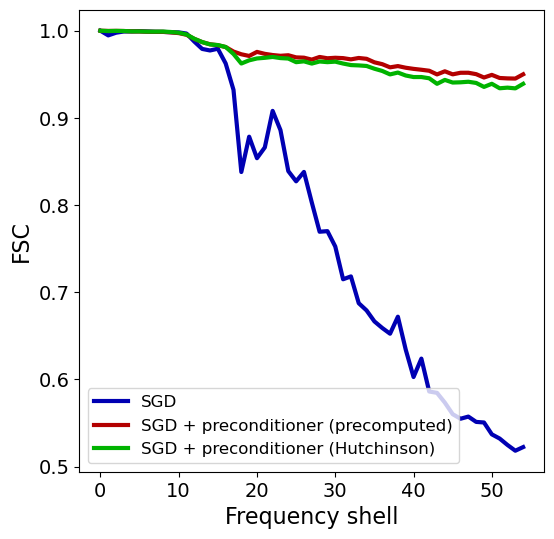

In [221]:
plt.plot((fsc_sgd[10]), linewidth=3, c=(0,0,0.7))
plt.plot((fsc_sgd_p[10]), linewidth=3, c=(0.7,0,0))
plt.plot((fsc_o[10]), linewidth=3, c=(0,0.7,0))
plt.legend(['SGD', 'SGD + preconditioner (precomputed)', 'SGD + preconditioner (Hutchinson)'], fontsize=12)
#plt.title("Fourier shell correlation (final epoch)", fontsize=22)
plt.xlabel("Frequency shell", fontsize=16)
plt.ylabel("FSC", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

if savefig:
    plt.savefig(f"post_thresh_shell_error.eps")#, bbox_inches='tight')

In [236]:
savefig = False

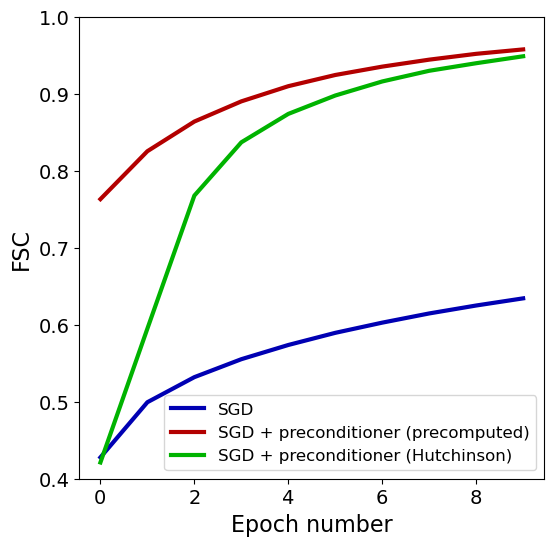

In [237]:
# Plot at idx_shell 9, 16, 39

N_shells = averr_rec.shape[1]
idx_shell = 39

plt.plot(fsc_sgd[1:,idx_shell], linewidth=3, c = (0,0,0.7))
plt.plot(fsc_sgd_p[1:, idx_shell], linewidth=3, c = (0.7,0,0))
plt.plot(fsc_o[1:, idx_shell], linewidth=3, c = (0,0.7,0))
#plt.plot(fsc_o_nothresh[1:, idx_shell])
plt.ylim([0.4,1])

#plt.title(f"FSC at Fourier shell {idx_shell+1}/{N_shells}", fontsize=22)

plt.legend(['SGD', 'SGD + preconditioner (precomputed)', 'SGD + preconditioner (Hutchinson)'], fontsize=12)
plt.xlabel("Epoch number", fontsize=16)
plt.ylabel("FSC", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

if savefig:
    plt.savefig(f"post_thresh_epoch_error_shell{idx_shell+1}.eps")


### The heatmaps with the errors

In [42]:
print(averr_rec.shape)
print(jnp.tile(jnp.max(averr_rec, axis=0, keepdims=True), (averr_rec.shape[0], 1)).shape)

(11, 55)
(11, 55)


In [43]:
# To allow for a better comparison between methods across epochs, 
# it's better to normalize each epoch

averr_rec_norm = averr_rec/np.tile(jnp.max(averr_rec, axis=0, keepdims=True), (averr_rec.shape[0], 1))
averr_rec_p_1000_norm = averr_rec_p_1000/np.tile(jnp.max(averr_rec_p_1000, axis=0, keepdims=True), (averr_rec.shape[0], 1))
averr_rec_o_norm = averr_rec_o/np.tile(jnp.max(averr_rec_o, axis=0, keepdims=True), (averr_rec.shape[0], 1))

In [44]:
print(jnp.min(jnp.log(averr_rec_norm)))
print(jnp.min(jnp.log(averr_rec_p_1000_norm)))
print(jnp.min(jnp.log(averr_rec_o_norm)))

print(jnp.max(jnp.log(averr_rec_norm)))
print(jnp.max(jnp.log(averr_rec_p_1000_norm)))
print(jnp.max(jnp.log(averr_rec_o_norm)))

clim_min = jnp.min(jnp.array([jnp.min(np.log(averr_rec_norm)), jnp.min(np.log(averr_rec_p_1000_norm)), jnp.min(np.log(averr_rec_o_norm))]))
clim_max = jnp.max(jnp.array([jnp.max(np.log(averr_rec_norm)), jnp.max(np.log(averr_rec_p_1000_norm)), jnp.max(np.log(averr_rec_o_norm))]))

print(clim_min)
print(clim_max)

-10.844622819030961
-7.8788009573419915
-8.379535308898232
0.0
0.0
0.0
-10.844622819030961
0.0


In [30]:
savefig = False

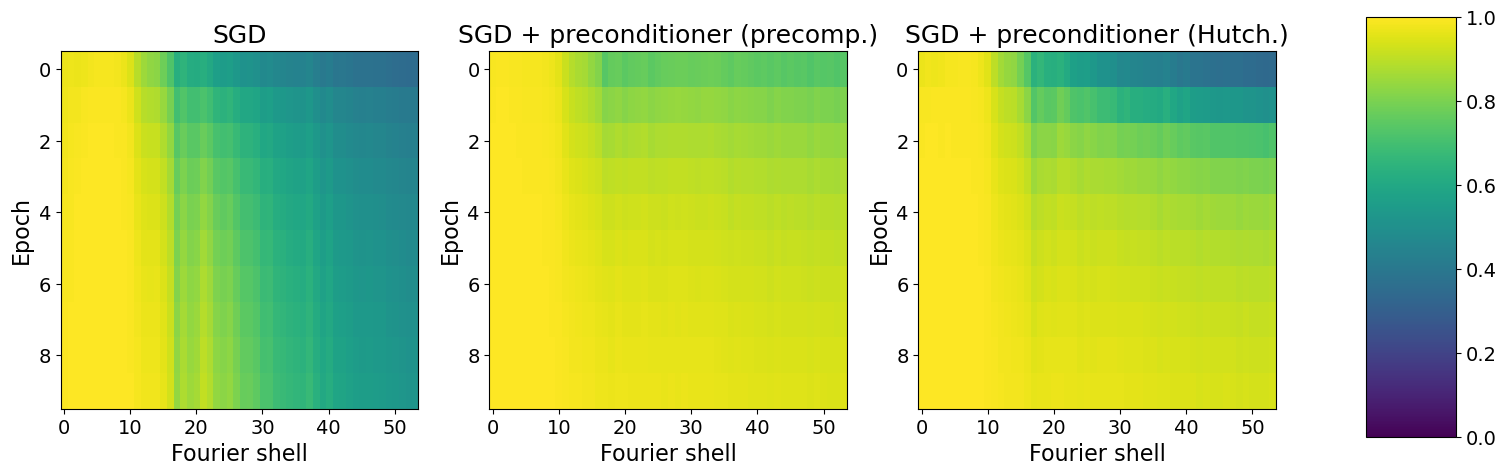

In [47]:
clim_min = 0
clim_max = 1

def forceAspect(ax, aspect=1):
    im = ax.get_images()
    extent = im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

plt.rcParams["figure.figsize"]=18, 6

fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(fsc_sgd[1:,1:], vmin=clim_min, vmax=clim_max)
forceAspect(ax)
plt.xlabel('Fourier shell', fontsize=16)
plt.ylabel('Epoch', fontsize=16)
plt.title('SGD', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax = fig.add_subplot(132)
ax.imshow(fsc_sgd_p[1:,1:],  vmin=clim_min, vmax=clim_max)
forceAspect(ax)
plt.xlabel('Fourier shell', fontsize=16)
plt.ylabel('Epoch', fontsize=16)
plt.title('SGD + preconditioner (precomp.)', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax = fig.add_subplot(133)
im = ax.imshow(fsc_o[1:,1:],  vmin=clim_min, vmax=clim_max)
forceAspect(ax)
plt.xlabel('Fourier shell', fontsize=16)
plt.ylabel('Epoch', fontsize=16)
plt.title('SGD + preconditioner (Hutch.)', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.rcParams["figure.figsize"]=6, 6

if savefig:
    plt.savefig(f"post_thresh_heatmap_all.eps", bbox_inches='tight')

### And separate to save

In [61]:
savefig = True

In [62]:
clim_min = 0
clim_max = 1

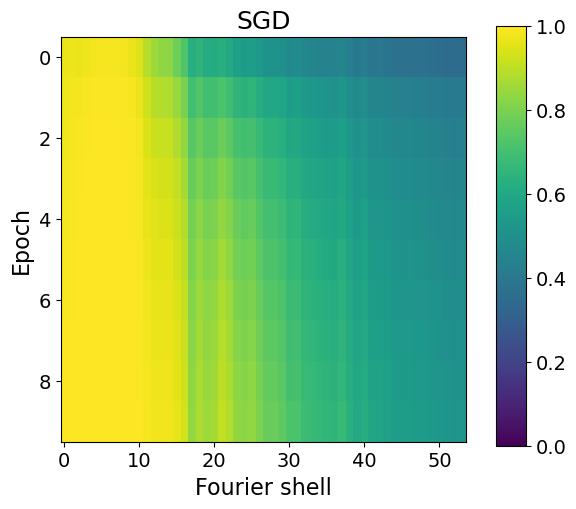

In [69]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow((fsc_sgd[1:,1:]), vmin=clim_min, vmax=clim_max)
#ax.imshow(jnp.log(averr_rec_norm[1:,1:]), vmin=clim_min, vmax=clim_max)

forceAspect(ax)
plt.xlabel('Fourier shell', fontsize=16)
plt.ylabel('Epoch', fontsize=16)
plt.title('SGD', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

if savefig:
    plt.savefig(f"post_thresh_heatmap_SGD.eps", bbox_inches='tight')

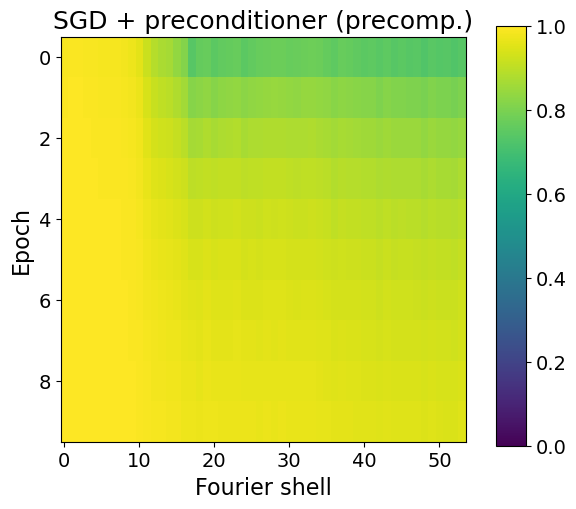

In [68]:
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.imshow(jnp.log(averr_rec_p_1000_norm[1:,1:]),  vmin=clim_min, vmax=clim_max)
ax.imshow((fsc_sgd_p[1:,1:]),  vmin=clim_min, vmax=clim_max)
forceAspect(ax)
plt.xlabel('Fourier shell', fontsize=16)
plt.ylabel('Epoch', fontsize=16)
plt.title('SGD + preconditioner (precomp.)', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

if savefig:
    plt.savefig(f"post_thresh_heatmap_SGD_p.eps", bbox_inches='tight')

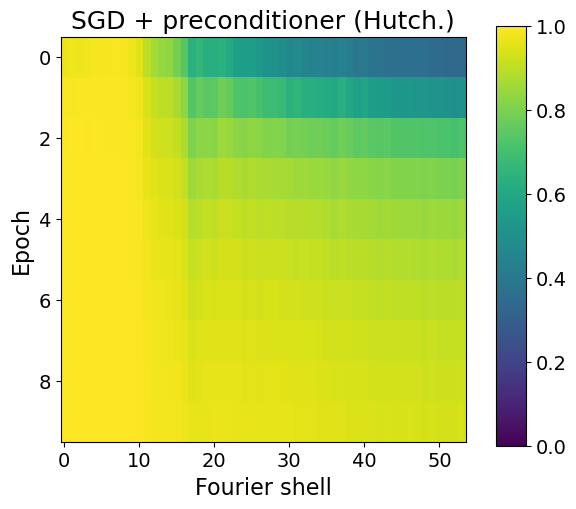

In [67]:
fig = plt.figure()
ax = fig.add_subplot(111)
#im = ax.imshow(jnp.log(averr_rec_o_norm[1:,1:]),  vmin=clim_min, vmax=clim_max)
im = ax.imshow((fsc_o[1:,1:]),  vmin=clim_min, vmax=clim_max)

forceAspect(ax)
plt.xlabel('Fourier shell', fontsize=16)
plt.ylabel('Epoch', fontsize=16)
plt.title('SGD + preconditioner (Hutch.)', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

if savefig:
    plt.savefig(f"post_thresh_heatmap_SGD_o.eps", bbox_inches='tight')

## Same info as the heatmaps, but gradient color line plots

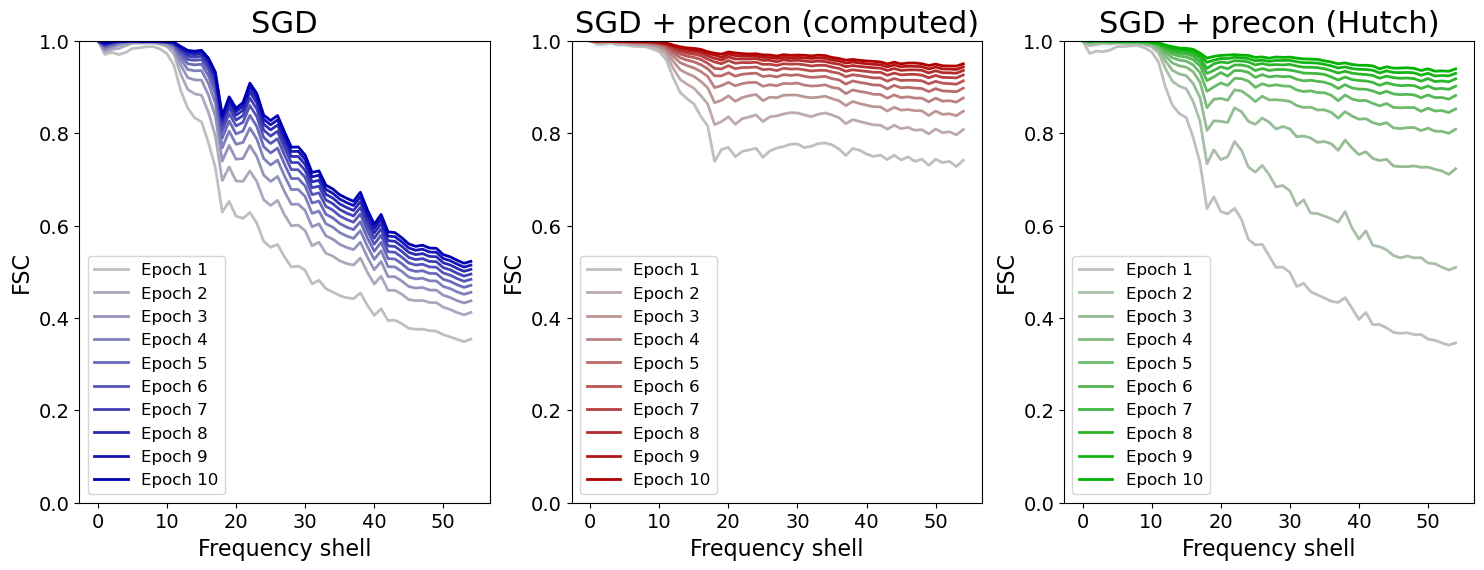

In [156]:
crange_color = np.linspace(0.75, 0.7, 10)
crange_other = np.linspace(0.75, 0.0, 10)

lgd = ['Epoch 1','Epoch 2','Epoch 3','Epoch 4','Epoch 5','Epoch 6','Epoch 7','Epoch 8','Epoch 9','Epoch 10']

plt.rcParams["figure.figsize"]=18, 6

plt.subplot(131)
for i in range(1,11):
    c = (crange_other[i-1], crange_other[i-1], crange_color[i-1])
    plt.plot(fsc_sgd[i,:], color=c, linewidth=2)
plt.ylim([0,1])
plt.legend(lgd, fontsize=12)
plt.title('SGD', fontsize=22)
plt.xlabel("Frequency shell", fontsize=16)
plt.ylabel("FSC", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
    
plt.subplot(132)
for i in range(1,11):
    c = (crange_color[i-1], crange_other[i-1], crange_other[i-1])
    plt.plot(fsc_sgd_p[i,:], color=c, linewidth=2)
plt.ylim([0,1])
plt.legend(lgd, fontsize=12)
plt.title('SGD + precon (computed)', fontsize=22)
plt.xlabel("Frequency shell", fontsize=16)
plt.ylabel("FSC", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(133)
for i in range(1,11):
    c = (crange_other[i-1], crange_color[i-1], crange_other[i-1])
    plt.plot(fsc_o[i,:], color=c, linewidth=2)
plt.ylim([0,1])
plt.legend(lgd, fontsize=12)
plt.title('SGD + precon (Hutch)', fontsize=22)
plt.xlabel("Frequency shell", fontsize=16)
plt.ylabel("FSC", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.rcParams["figure.figsize"]=6, 6


In [168]:
savefig = False

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


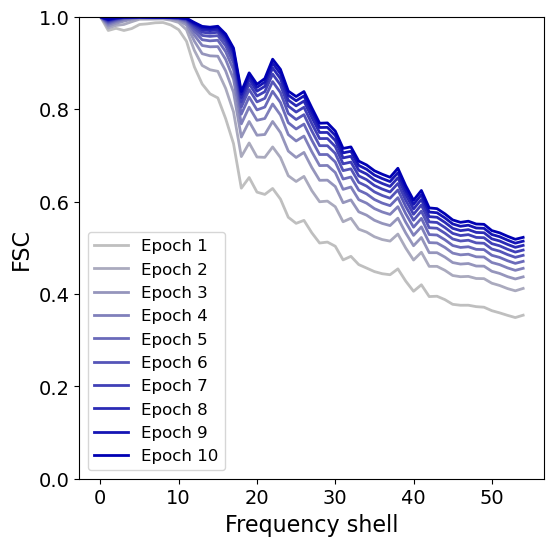

In [165]:
#plt.subplot(131)
for i in range(1,11):
    c = (crange_other[i-1], crange_other[i-1], crange_color[i-1])
    plt.plot(fsc_sgd[i,:], color=c, linewidth=2)
plt.ylim([0,1])
plt.legend(lgd, fontsize=12)
#plt.title('SGD', fontsize=22)
plt.xlabel("Frequency shell", fontsize=16)
plt.ylabel("FSC", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
    
if savefig:
    plt.savefig(f"fsc_shell_gradient_color_sgd.eps", bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


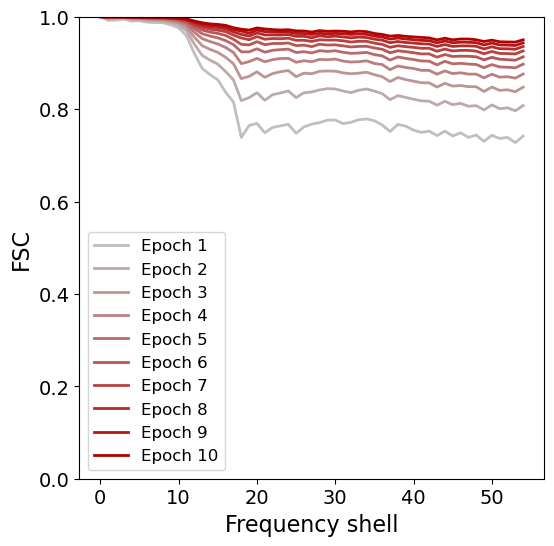

In [166]:
for i in range(1,11):
    c = (crange_color[i-1], crange_other[i-1], crange_other[i-1])
    plt.plot(fsc_sgd_p[i,:], color=c, linewidth=2)
plt.ylim([0,1])
plt.legend(lgd, fontsize=12)
#plt.title('SGD + precon (computed)', fontsize=22)
plt.xlabel("Frequency shell", fontsize=16)
plt.ylabel("FSC", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

if savefig:
    plt.savefig(f"fsc_shell_gradient_color_sgd_p.eps", bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


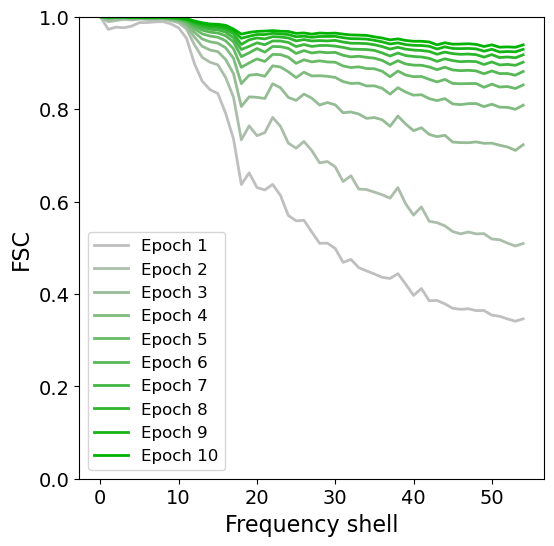

In [167]:
for i in range(1,11):
    c = (crange_other[i-1], crange_color[i-1], crange_other[i-1])
    plt.plot(fsc_o[i,:], color=c, linewidth=2)
plt.ylim([0,1])
plt.legend(lgd, fontsize=12)
#plt.title('SGD + precon (Hutch)', fontsize=22)
plt.xlabel("Frequency shell", fontsize=16)
plt.ylabel("FSC", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

if savefig:
    plt.savefig(f"fsc_shell_gradient_color_sgd_o.eps", bbox_inches='tight')

### Shell points

In [63]:
from src.fsc import average_shells_2D

# Use the same dr as in average_shells_3D
x_freq = jnp.fft.fftfreq(int(x_grid[1]), 1/(x_grid[0]*x_grid[1]))
X, Y, Z = jnp.meshgrid(x_freq, x_freq, x_freq)
r = jnp.sqrt(X**2 + Y**2 + Z**2)
dr = r[1,1,1]

res, _, shell_pts_2d = average_shells_2D(mask2d.reshape((192,192)), x_grid, dr)

In [64]:
print(res.shape)
print(shell_pts_2d.shape)
print(shell_pts.shape)

(55,)
(55,)
(55,)


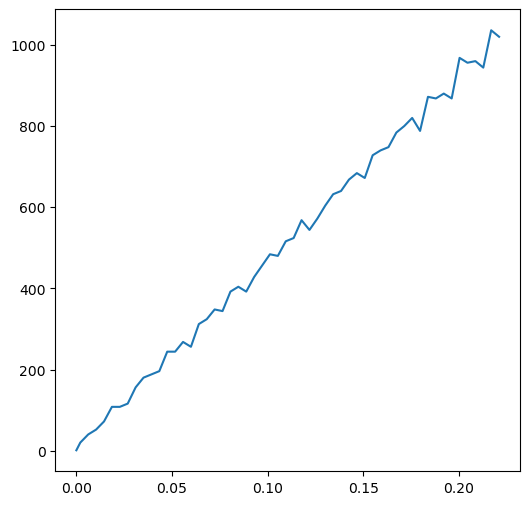

In [65]:
plt.plot(res, shell_pts_2d)

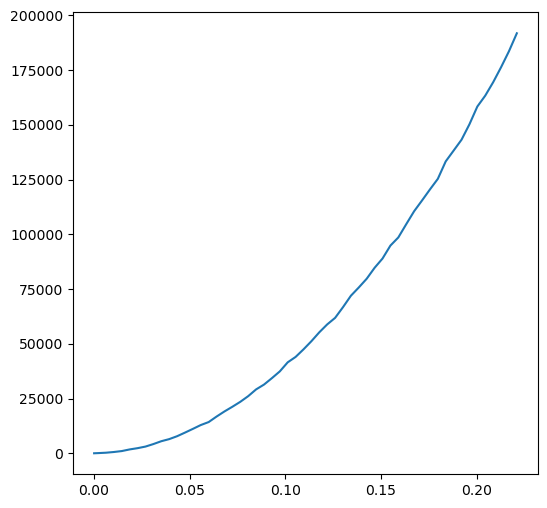

In [66]:
plt.plot(res, shell_pts)

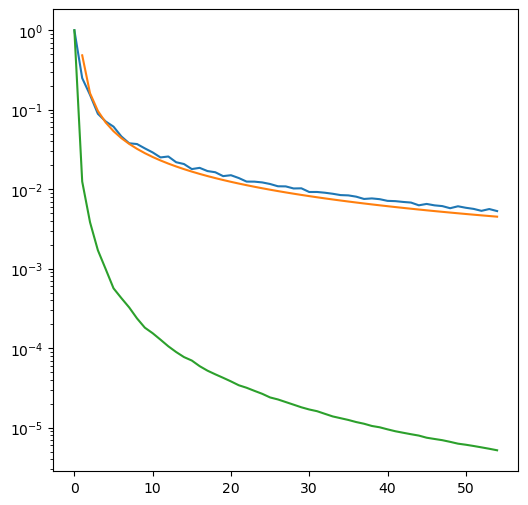

In [67]:
plt.semilogy(shell_pts_2d/shell_pts)
plt.semilogy(1/(2*res)/500)
plt.semilogy(1/shell_pts)

In [68]:
interp_method = "tri"
#n_epochs = 2
n_epochs = 400

precon_filename = f"{out_dir}/D0_{interp_method}_nx{nx}_N{N}_{n_epochs}epochs.npy"
D0 = jnp.load(precon_filename)


In [69]:
print(jnp.min(jnp.abs(D0)))
print(jnp.max(jnp.abs(D0)))
print(jnp.max(jnp.abs(D0))/jnp.min(jnp.abs(D0)))

1.532902781530639e-09
0.020029651523419335
13066485.210118325


In [70]:
13066485/8

1633310.625

In [71]:
shell_pts_2d[-1]/shell_pts[-1]

Array(0.00531826, dtype=float64)

In [72]:
res, D0_shell_means, _, _, _ = average_shells(jnp.abs(D0), x_grid)

In [73]:
D0_shell_means[-1] * shell_pts_2d[-1]/shell_pts[-1]

Array(4.87645038e-06, dtype=float64)